In [ ]:
#Простейшая рекомендательная система

In [1]:
#Подключаю все необходимые библиотеки

from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
import numpy as np

In [ ]:
#Парсер сайта ЕГСН, для получения актуальной информации о стоимости квартир в Москве
data = []
for i in range(1,2306,1):
    url = 'https://www.egsnk.ru/kvartiry/kupit/p'
    url = url + str(i)
    page = requests.get(url)
    if page.status_code != 200:
        print(page.status_code)
        exit()
    soup = BeautifulSoup(page.text, features="html.parser")
    flats = soup.find_all('div', class_='res_row clearfix')  
    for flat in flats:
        block_01 = flat.find('div', class_='res_right')
        block_02_01 = flat.find_all('div', class_='mt8')
        block_02_02 = block_02_01[0]
        block_03 = flat.find('div', class_='res_text fs15')
        block_03_02 = block_03.find_all('div')
        block_03_03 = block_03_02[0]
            
        text_01 = block_01.text.strip().replace('\n', '\t')
        cost = float(''.join([x for x in text_01 if x.isdigit() or x == '.']))
        description = block_03_03.text.strip().replace('\n', '\t')
        info = block_03.text.strip().replace('\n', '\t')
        address = block_02_02.text.strip().replace('\n', '\t')

        data.append({
                'cost': cost,
                'address': address,
                'description': description,
                'all_info': info,
            })
df = pd.DataFrame(data).to_csv('data_all.csv')

In [5]:
flat.head(5)

,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),floor,floors,description
0,1 – комнатная,5000000,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1 комната,4500000,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,1 – комнатная,10900000,36.1,301939.1,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,1 комната,3650000,93.0,39247.3,"Матросская Тишина ул., 23/7",сокольники,1428.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,доля (1/2),1200000,72.3,16597.5,"Центральная ул., 6",NaN,0.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...


In [ ]:
#Обработка данных из Kaggle
flat_full =pd.read_csv('moscow_full_2.0.csv')
flat_full[['rooms', 'square','floor1']] = flat_full['title']. str.split(', ', 0 , expand= True )# разделяю значения по столбцам
flat_full.rename(columns = {'adress' : 'address'}, inplace = True) # меняю наименование на корректное
flat_full = flat_full.drop(columns='title') #удаляю колонку старого title
flat_full[['floor2','floor3']] = flat_full['floor1'].str.split('э', 0 , expand= True ) # разделяю floor1 значения по столбцам
flat_full[['floor', 'floors']] = flat_full['floor2']. str.split('/', 0 , expand= True ).fillna(0)# разделяю floor2 значения по столбцам
flat_full['floor']=flat_full['floor'].astype("int") # перевожу этаж в тип INT
flat_full['floors']=flat_full['floors'].astype("int") # перевожу этажи в тип INT
flat_full[['square(м²)','DEL']] = flat_full['square'].str.split('м', 0 , expand= True ) # удаляю ненужные м²
flat_full['square(м²)']=flat_full['square(м²)'].astype("float")# перевожу площадь в тип флоат
                               # Очищаю cost_for_meter(₽)
flat_full[['cost_for_meter(₽)', 'DEL1']] = flat_full['cost_for_meter']. str.split(' ₽ ', 0 , expand= True )# разделяю значения по столбцам
flat_full['cost_for_meter(₽)']=flat_full['cost_for_meter(₽)'].fillna(0)# меняю нан на 0
mask = flat_full['cost_for_meter(₽)'].str.fullmatch(r'[\d ]*')# ввожу переменную с регулярным выражением
flat_full.loc[mask, 'cost_for_meter(₽)'] = flat_full.loc[mask, 'cost_for_meter(₽)'].str.replace(' ', '')# меняю replace ом пробел
flat_full['cost_for_meter(₽)']=flat_full['cost_for_meter(₽)'].astype("int")# перевожу в флоат
flat_full['cost_for_meter(₽)'] = (flat_full['cost_for_meter(₽)'] + ((flat_full['cost_for_meter(₽)'])*(34/100)))
                               # Очищаю cost
flat_full[['cost(₽)', 'DEL2']] = flat_full['cost']. str.split('₽', 0 , expand= True )# разделяю значения по столбцам
flat_full['cost(₽)']=flat_full['cost(₽)'].fillna(0)# меняю нан на 0
mask = flat_full['cost(₽)'].str.fullmatch(r'[\d ]*')# ввожу переменную с регулярным выражением
flat_full.loc[mask, 'cost(₽)'] = flat_full.loc[mask, 'cost(₽)'].str.replace(' ', '')# меняю replace ом пробел
flat_full['cost(₽)']=flat_full['cost(₽)'].astype("float")# перевожу в float
flat_full['cost(₽)'] = (flat_full['cost(₽)'] + ((flat_full['cost(₽)'])*0.34)) # увеличиваю на 34%
                                # Получаю расстояние в метрах
flat_full['min_int']= flat_full['metro'].str.extract(r'([-+]?(?:\d+(?:\.\d*)?|\.\d+))(?= м| км)').fillna(0) #Выделяю только цифры
flat_full['min_int']=flat_full['min_int'].astype("float")# перевожу в INT
flat_full['alpha1'] = flat_full['metro'].str.contains(' км') # нахожу слова -км истина -есть ложь нет
flat_full['alpha1']=flat_full['alpha1'].replace({False:1,	True:1000}).fillna(0).astype("int") # меняю ложь на 1  и истину на 1000 (в 1 км =1000м), и перевожу в INT
flat_full['distance(м)']= flat_full['alpha1']*flat_full['min_int']  # получаю расстояние от метров метрах
                                # выделяю название метро
flat_full['metro_name']= flat_full['metro'].str.extract(r'(.*(?= \d))') # выделяю название метро
flat_full ['metro_name'] = flat_full ['metro_name'].str.lower()# перевод названий станций в нижний регистр
                                # удаляю промежуточные колонки
flat_full = flat_full.drop(['floor3','floor2','floor1','DEL','square', 'cost_for_meter', 'DEL1','cost','DEL2','min_int','alpha1','metro'],axis=1)  #удаляю промежуточные колонки
flat_full= flat_full[['rooms','cost(₽)','square(м²)','cost_for_meter(₽)','address','metro_name','distance(м)','floor','floors','description']]#порядок столбцов
flat_full.to_csv('moscow_flat20.csv',index=False)
flat_full.head(5)

In [3]:
flat_full.head(5)

,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),floor,floors,description
0,Квартира своб. планировки,50920000.00,130.00,391692.72,"Москва, 3-я улица Ямского Поля, 9к3",белорусская,407.0,5,5,Представляю Вашему вниманию 2-х уровневый пент...
1,2-комн. квартира,62980000.00,93.00,677203.84,"Москва, Ленинградский проспект, 36с31",динамо,612.0,6,10,В премиальном ЖК Hyatt Regency предлагаем Ваше...
2,1-комн. квартира,11792000.00,36.00,327554.96,"Москва, Печорская улица, 5",бабушкинская,792.0,5,16,"Свободная продажа, никто не прописан. В кварти..."
3,1-комн. квартира,11806521.58,47.59,248088.94,пр-т Нахимовский,профсоюзная,1400.0,0,0,Многофункциональный комплекс «Нахимов» предста...
4,1-комн. квартира,15678000.00,36.00,435500.00,"Москва, Новорогожская улица, 11к2",римская,446.0,6,12,Собственник. Риелторов и прочих помогателей ПР...


In [ ]:
# Слияние датасетов
frames = [flat, flat_full]
result = pd.concat(frames)
result.to_csv('Realty.csv',index=False) 

In [4]:
result.head(5)

,rooms,cost(₽),square(м²),cost_for_meter(₽),address,metro_name,distance(м),floor,floors,description
0,1 – комнатная,5000000.0,31.0,161290.3,"Центральная ул., 6",бульвар дмитрия донского,4995.0,2,4,Прекрасная однокомнатная квартира в доме с лиф...
1,1 комната,4500000.0,98.0,45918.4,"Коптевская ул., 28к2",коптево,420.0,3,5,"Светлая, просторная комната 19 кв. метров. Отд..."
2,1 – комнатная,10900000.0,36.1,301939.1,"15-я Парковая ул., 1/123 корп.2",измайловская,1680.0,1,9,"Первомайская, 15 мин. пешкомТёплая уютная квар..."
3,1 комната,3650000.0,93.0,39247.3,"Матросская Тишина ул., 23/7",сокольники,1428.0,4,5,"в шаговой доступности парк Сокольники. , Разви..."
4,доля (1/2),1200000.0,72.3,16597.5,"Центральная ул., 6",NaN,0.0,1,2,Ильинское с.Все коммуникации центральные.Кварт...


In [ ]:
#Распределение случайной величины

#создание области графика
plt.figure(figsize=(20,10), dpi=80)
#считывание файлов csv
flat_total= pd.read_csv('Realty.csv')
flat_22 = pd.read_csv('moscow_flat22.csv')
flat_20 = pd.read_csv('moscow_flat20.csv')
#построение распределений
sns.kdeplot(flat_20['cost_for_meter(₽)'],log_scale=True,shade=True,bw_method=0.3,color="deeppink", label="Данные за 2020г", alpha=.3)
sns.kdeplot(flat_22['cost_for_meter(₽)'],log_scale=True,shade=True,bw_method=0.3,color="g", label="Данные за 2022г", alpha=.3)
sns.kdeplot(flat_total['cost_for_meter(₽)'],log_scale=True,shade=True,bw_method=0.3,color="orange", label="Объединенные данные", alpha=.3)
#управление настройками сетки
plt.grid(axis='x',which='both', linestyle=':',color="black",alpha=.5)
plt.grid(axis='y',which='major', linestyle=':',color="black",alpha=.5)
#надписи координатных осей
plt.minorticks_on()
#plt.xlabel('Стоимость за м²(в логарифмическом масштабе)', fontsize=16)
#plt.ylabel('Плотность', fontsize=16)
plt.tick_params(axis='x',which='both', length=10, width=2)
plt.tick_params(axis='y',which='major', length=10, width=2)
plt.xticks(color="b", size=15)
plt.yticks(color="b", size=15)
#титул, легенда 
plt.title('Ядерная оценка плотности', fontsize=22)
plt.legend()
#обновление графика вне интер-актива
plt.show()


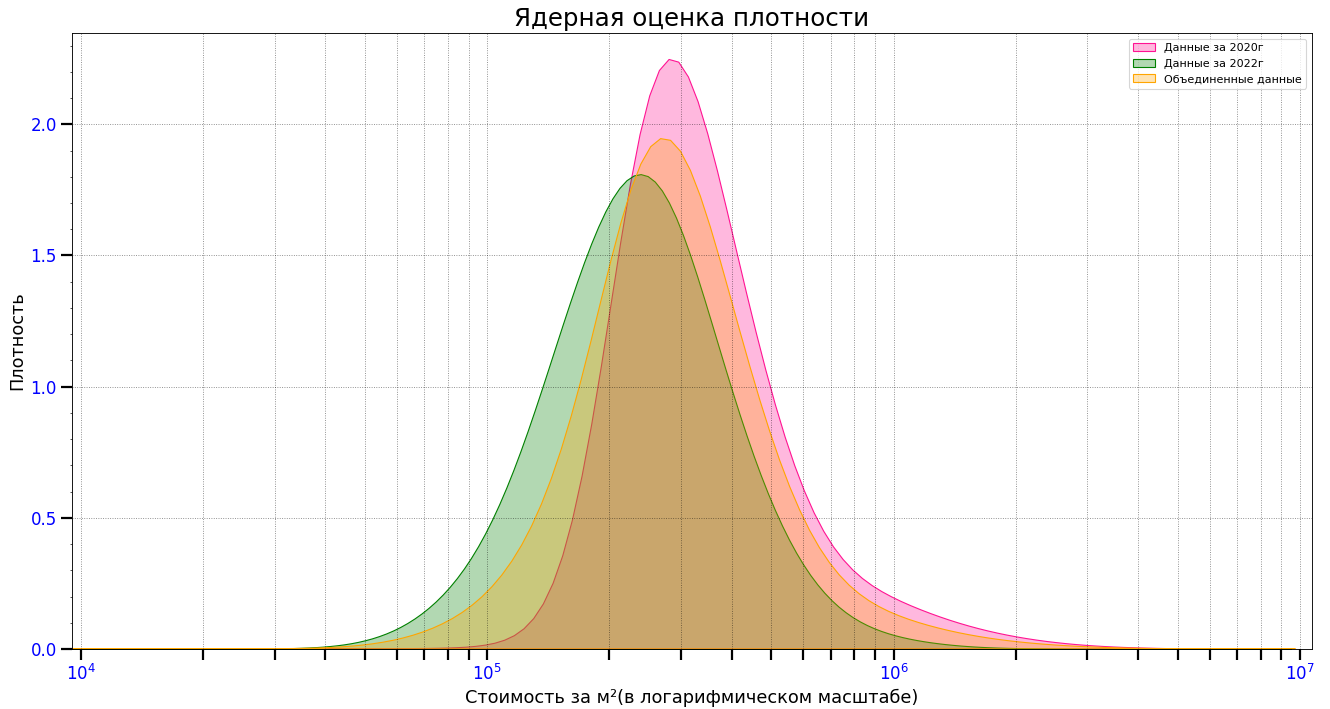

In [1]:
from IPython import display
display.Image("Log_all.png")

In [ ]:
#Парсер удаленности метро от центра


#  список данных
data = []
# без цикла
page = requests.get('https://m.101hotels.com/recreation/russia/moskva/infrastructure/metro?ysclid=la3a4g68is638416669&page=23')
# проверка статуса страниц 
if page.status_code != 200:
    print(page.status_code)
    exit()
# индексация информации по выбранным тегам в блоки
soup = BeautifulSoup(page.text, features="html.parser")
metros = soup.find_all('li', class_='tiled_list_item')  
for metro in metros:
    block_01 = metro.find('div', class_='link__title')
    block_02 = metro.find('div', class_='center-distance')
# перевод блоков в строки и обработка строк
    name = block_01.text.strip().replace('\n', '\t')
    center_distance = block_02.text.strip().replace('\n', '\t')
# добавление в список данных
    data.append({
      'metro_name': name,
      'center_distance': center_distance,
            })
# выходной выйл
df = pd.DataFrame(data).to_csv('metro.csv',index=False)
# Обработка данных
metro =pd.read_csv('metro.csv')
#Выделяю только цифры
metro['center_distance']= metro['center_distance'].str.extract(r'([-+]?(?:\d+(?:\.\d*)?|\.\d+))(?= км)').fillna(0)
# перевожу расстояние до метро в метры, тип флоат
metro['center_distance/m']=(metro['center_distance'].astype("float"))*1000
# Перевод названий станций в нижний регистр
metro['metro_name'] = metro['metro_name'].str.lower()
#Удаляю столбец center_distance
metro = metro.drop(['center_distance'],axis=1) 
# выходной выйл
metro.to_csv('metro.csv',index=False)

In [6]:
metro.head(5)

,metro_name,center_distance/m
0,театральная,600.0
1,чеховская,1500.0
2,охотный ряд,500.0
3,тверская,1500.0
4,площадь революции,400.0


In [ ]:
#Объединение по 'metro_name' и удаление текстовых данных

#считывание файлов csv
Realty = pd.read_csv('Realty.csv')
metro = pd.read_csv('metro.csv') 
res = Realty.merge(metro, how="left")#объединение файлов csv по 'metro_name' 
res['center_distance/m']=res['center_distance/m'].fillna(0) # меняю нан на 0
#Удаляю текстовые данные (оставляю только численные)
res = res.drop(['address', 'description','rooms','metro_name'],axis=1)
res.to_csv('Res.csv',index=False) #Сохраняю без индекса

In [7]:
res.head(5)

,cost(₽),square(м²),cost_for_meter(₽),distance(м),floor,floors,center_distance/m
0,5000000.0,31.0,161290.3,4995.0,2,4,20600.0
1,4500000.0,98.0,45918.4,420.0,3,5,11400.0
2,10900000.0,36.1,301939.1,1680.0,1,9,10700.0
3,3650000.0,93.0,39247.3,1428.0,4,5,5400.0
4,1200000.0,72.3,16597.5,0.0,1,2,0.0


In [10]:
#Простейшие рекомендации:
df = pd.read_csv('Res.csv')
# случайный образцовый объект недвижимости и информацию о нем
idx = np.random.randint(0,100732)
idx
obj = df.loc[idx]
print(obj)
#  порог значения корреляции для попадания в финальный результат равен 0.995
THRES = 0.995
# ответ рекомендательной системы будет выводится сразу в датафрейм
# чтобы не прописывать создание фрема с нуля - создам его из имеющейся таблицы
df_recommend = df.head(0).copy()
# цикл по всем объектам в продаже, кроме образцового
for row in df.index:
    # коэффициент корреляции между двумя объектами
    corr = obj.corr(df.loc[row])
    # если коэффициент больше или равен значению порога - добавляетя запись в новую таблицу вместе с коэффициентом
    if corr >= THRES: 
        df_recommend = pd.concat([df_recommend, df.query('index == @row')])
        df_recommend.loc[row, 'corr_coef'] = corr
# сортировка результата по значению коэффициента и десятку лучших + первая строка образцовая
df_recommend.sort_values(by='corr_coef', ascending=False, inplace=True)
df_recommend = df_recommend.head(11)
print(df_recommend.head(11))

cost(₽)              38626829.28
square(м²)                165.60
cost_for_meter(₽)      233253.80
distance(м)               755.00
floor                      45.00
floors                     56.00
center_distance/m       10000.00
Name: 76219, dtype: float64
           cost(₽)  square(м²)  cost_for_meter(₽)  distance(м)  floor  floors  \
76219  38626829.28       165.6           233253.8        755.0     45      56   
88820  38535403.76       165.6           232701.7        755.0     44      56   
47559  38535405.10       165.6           232701.7        762.0     44      56   
88814  38443979.58       165.6           232149.6        755.0     43      56   
76194  38261131.22       165.6           231045.5        755.0     41      56   
60946  38169707.04       165.6           230493.4        755.0     40      56   
88819  38078281.52       165.6           229941.3        755.0     39      56   
80412  37986857.34       165.6           229389.2        755.0     38      56   
60619  37895